This lab on Ridge Regression and the Lasso is a Python adaptation of p. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. Based on the work of R. Jordan Crouser at Smith College for SDS293: Machine Learning (Spring 2016).

Before you start upgrade your scikit-learn library to version 1.0. 

In [1]:
def check_sklearn():
    from importlib_metadata import metadata
    version = metadata('scikit-learn').get('Version')
    # print(version)
    major, minor = list(map(int, version.split('.')[:2]))
    if major==0:
        print(f"sklearn version is {version}, please upgrade by uncommenting and running the next cell!")
    else:
        print(f"Your sklearn version=`{version}` seems to be up to date") 
check_sklearn()

Your sklearn version=`1.0` seems to be up to date


In [2]:
#! pip install -U scikit-learn

# 6.6: Ridge Regression and the Lasso

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.datasets as smd
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, lasso_path, lars_path
from sklearn.metrics import mean_squared_error

We will use the `sklearn` package in order to perform ridge regression and
the lasso. The main functions in this package that we care about are `Ridge()`, which can be used
to fit ridge regression models, and `Lasso()` which will fit lasso models. They also have cross-validated counterparts: `RidgeCV()` and `LassoCV()`. We'll use these a bit later.

Before proceeding, let's first ensure that the missing values have
been removed from the data, as described in the previous lab.

In [6]:
use_smith_edu = False  # or True
if use_smith_edu:
    url = ''
    df = pd.read_csv('https://www.science.smith.edu/~jcrouser/SDS293/data/Hitters.csv')
    df = df.set_index('Player')
else:
    df = smd.get_rdataset('Hitters', 'ISLR')
    df.data.__doc__ = df.__doc__
    df = df.data

df = df.dropna()
df.head()


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


We will now perform ridge regression and the lasso in order to predict `Salary` on
the `Hitters` data. Let's set up our data:

In [7]:
y = df.Salary

dummies = pd.get_dummies(df[['League', 'Division', 'NewLeague']])

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')

# Define the feature set X.
X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, -Alan Ashby to -Willie Wilson
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   AtBat        263 non-null    float64
 1   Hits         263 non-null    float64
 2   HmRun        263 non-null    float64
 3   Runs         263 non-null    float64
 4   RBI          263 non-null    float64
 5   Walks        263 non-null    float64
 6   Years        263 non-null    float64
 7   CAtBat       263 non-null    float64
 8   CHits        263 non-null    float64
 9   CHmRun       263 non-null    float64
 10  CRuns        263 non-null    float64
 11  CRBI         263 non-null    float64
 12  CWalks       263 non-null    float64
 13  PutOuts      263 non-null    float64
 14  Assists      263 non-null    float64
 15  Errors       263 non-null    float64
 16  League_N     263 non-null    uint8  
 17  Division_W   263 non-null    uint8  
 18  NewLeague_N  263 non-null    uint8

# 6.6.1 Ridge Regression
The `Ridge()` function has an alpha argument ($\lambda$, but with a different name!) that is used to tune the model. We'll generate an array of alpha values ranging from very big to very small, essentially
covering the full range of scenarios from the null model containing
only the intercept, to the least squares fit:

In [8]:
alphas = 10**np.linspace(10, -2, 100)
alphas

array([1.00000000e+10, 7.56463328e+09, 5.72236766e+09, 4.32876128e+09,
       3.27454916e+09, 2.47707636e+09, 1.87381742e+09, 1.41747416e+09,
       1.07226722e+09, 8.11130831e+08, 6.13590727e+08, 4.64158883e+08,
       3.51119173e+08, 2.65608778e+08, 2.00923300e+08, 1.51991108e+08,
       1.14975700e+08, 8.69749003e+07, 6.57933225e+07, 4.97702356e+07,
       3.76493581e+07, 2.84803587e+07, 2.15443469e+07, 1.62975083e+07,
       1.23284674e+07, 9.32603347e+06, 7.05480231e+06, 5.33669923e+06,
       4.03701726e+06, 3.05385551e+06, 2.31012970e+06, 1.74752840e+06,
       1.32194115e+06, 1.00000000e+06, 7.56463328e+05, 5.72236766e+05,
       4.32876128e+05, 3.27454916e+05, 2.47707636e+05, 1.87381742e+05,
       1.41747416e+05, 1.07226722e+05, 8.11130831e+04, 6.13590727e+04,
       4.64158883e+04, 3.51119173e+04, 2.65608778e+04, 2.00923300e+04,
       1.51991108e+04, 1.14975700e+04, 8.69749003e+03, 6.57933225e+03,
       4.97702356e+03, 3.76493581e+03, 2.84803587e+03, 2.15443469e+03,
      

Associated with each alpha value is a vector of ridge regression coefficients, which we'll
store in a matrix `coefs`. In this case, it is a $19 \times 100$
matrix, with 19 rows (one for each predictor) and 100
columns (one for each value of alpha). Remember that we'll want to standardize the
variables so that they are on the same scale. To do this, we can use the
`normalize = True` parameter:

In [53]:

ridge = make_pipeline(StandardScaler(), Ridge())

def coeff_and_mse(model, X, y, **params):
    estimator = model[-1] if isinstance(model, sklearn.pipeline.Pipeline) else model
    estimator.set_params(**params)
    mse =mean_squared_error(model.fit(X, y).predict(X), y)
    result = dict(zip(model[:-1].get_feature_names_out(), estimator.coef_))
    result['mse'] = mse
    result.update(params)
    return result
    
    
ridge_path = pd.DataFrame([coeff_and_mse(ridge, X, y, alpha=a) for a in alphas]).set_index('alpha')
ridge_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N,mse
alpha,,,,,,,,,,,,,,,,,,,,
1.000000e+10,0.000005,0.000005,0.000004,0.000005,0.000005,0.000005,0.000005,0.000006,0.000007,0.000006,0.000007,0.000007,0.000006,0.000004,3.012107e-07,-6.395428e-08,-1.691230e-07,-0.000002,-3.356510e-08,202734.236509
7.564633e+09,0.000006,0.000007,0.000005,0.000007,0.000007,0.000007,0.000006,0.000008,0.000009,0.000008,0.000009,0.000009,0.000008,0.000005,3.981828e-07,-8.454381e-08,-2.235706e-07,-0.000003,-4.437104e-08,202734.225998
5.722368e+09,0.000008,0.000009,0.000007,0.000009,0.000009,0.000009,0.000008,0.000011,0.000011,0.000011,0.000012,0.000012,0.000010,0.000006,5.263742e-07,-1.117620e-07,-2.955470e-07,-0.000004,-5.865581e-08,202734.212103
4.328761e+09,0.000011,0.000012,0.000009,0.000011,0.000012,0.000012,0.000011,0.000014,0.000015,0.000014,0.000015,0.000016,0.000013,0.000008,6.958357e-07,-1.477427e-07,-3.906955e-07,-0.000005,-7.753936e-08,202734.193735
3.274549e+09,0.000014,0.000016,0.000012,0.000015,0.000016,0.000016,0.000014,0.000019,0.000020,0.000019,0.000020,0.000021,0.000018,0.000011,9.198538e-07,-1.953073e-07,-5.164761e-07,-0.000007,-1.025022e-07,202734.169453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.053856e-02,-290.565733,336.039547,36.783312,-58.919331,-26.010245,134.636895,-17.778470,-384.094384,92.105310,-10.391640,471.394628,253.872789,-212.370325,78.762198,5.350006e+01,-2.225474e+01,3.126419e+01,-58.503548,-1.245482e+01,92018.987322
2.310130e-02,-290.692507,336.464367,37.037600,-59.311089,-26.244216,134.741106,-17.516885,-385.794898,90.881489,-11.280807,473.604369,255.476124,-212.728953,78.761896,5.355691e+01,-2.223273e+01,3.126106e+01,-58.482132,-1.243018e+01,92018.516466
1.747528e-02,-290.789150,336.790313,37.232619,-59.611894,-26.423634,134.820836,-17.317830,-387.078202,89.916997,-11.967363,475.303911,256.712435,-213.005133,78.761698,5.359983e+01,-2.221573e+01,3.125844e+01,-58.465774,-1.241105e+01,92018.242844


We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm,
when a large value of alpha is used, as compared to when a small value of alpha is
used. Let's plot and find out:

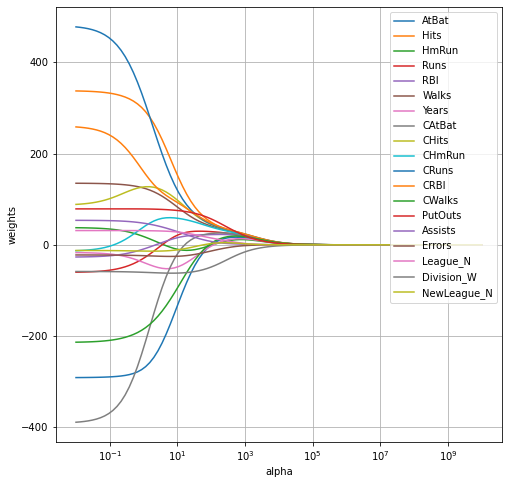

In [37]:
ridge_path[X.columns].plot(figsize=(8,8))
plt.legend(loc='upper right')
plt.xscale('log')
plt.axis('tight')
plt.ylabel('weights')
plt.grid()
plt.show()

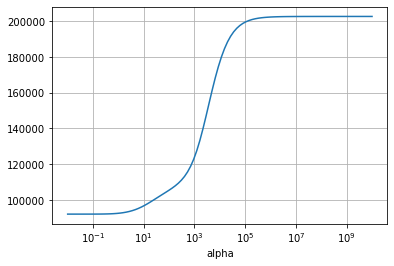

In [54]:
ridge_path['mse'].plot()
plt.xscale('log')
plt.grid()
plt.show()

In [55]:
# plt.plot(alphas, np.linalg.norm(coefs,axis=1))
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()

We now split the samples into a training set and a test set in order
to estimate the test error of ridge regression and the lasso:

In [56]:
# Split data into training and test sets
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

Next we fit a ridge regression model on the training set, and evaluate
its MSE on the test set, using $\lambda = 4$:

In [57]:
def print_result(estimator, X_test=None, y_test=None):
    intercept, coef = estimator[-1].intercept_, estimator[-1].coef_
    df = pd.DataFrame(coef[None], columns=estimator[0].feature_names_in_)
    df['intercept'] = intercept
    print('-'*20)
    print(f'alpha={estimator[-1].alpha}')
    print('-'*20)
    print(df.to_string(line_width=80, index=False))
    if not(X_test is None or y_test is None):
        pred = estimator.predict(X=X_test)
        print('-'*20)
        print(f'MSE {mean_squared_error(y_test, pred):.2f}')
        print('-'*20)

ridge2 = make_pipeline(StandardScaler(with_mean=True, with_std=True), 
                       Ridge(alpha=4))

# Fit a ridge regression on the training data
ridge2.fit(X_train, y_train)

print_result(ridge2, X_test, y_test)


--------------------
alpha=4
--------------------
      AtBat       Hits      HmRun    Runs       RBI     Walks      Years  \
-210.807322 193.076932 -51.437368 1.62407 81.458917 94.582539 -28.029476   

     CAtBat     CHits   CHmRun     CRuns       CRBI     CWalks    PutOuts  \
-117.924364 91.159632 91.76201 101.11545 117.598963 -38.434685 125.556071   

  Assists     Errors  League_N  Division_W  NewLeague_N  intercept  
25.559188 -18.518904  35.79205  -60.245442   -18.650623 532.709015  
--------------------
MSE 102144.52
--------------------


The test MSE when alpha = 4 is 106216. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [58]:
ridge3 = make_pipeline(StandardScaler(), 
                       Ridge(alpha = 10**10))
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
print_result(ridge3, X_test, y_test)

--------------------
alpha=10000000000
--------------------
   AtBat     Hits    HmRun     Runs      RBI    Walks    Years   CAtBat  \
0.000003 0.000003 0.000002 0.000003 0.000003 0.000003 0.000002 0.000003   

   CHits   CHmRun    CRuns     CRBI   CWalks  PutOuts       Assists  \
0.000003 0.000003 0.000004 0.000004 0.000003 0.000003 -4.856786e-08   

      Errors      League_N  Division_W   NewLeague_N  intercept  
1.736624e-07 -1.637144e-07   -0.000001 -1.325154e-07 532.709015  
--------------------
MSE 172862.22
--------------------


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This over-shrinking makes the model more biased, resulting in a higher MSE.

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test
MSE than fitting a model with just an intercept. We now check whether
there is any benefit to performing ridge regression with alpha = 4 instead of
just performing least squares regression. Recall that least squares is simply
ridge regression with alpha = 0.

In [59]:
ridge2 = make_pipeline(StandardScaler(), 
                       Ridge(alpha = 0))
ridge2.fit(X_train, y_train)             # Fit a ridge regression on the training data

print_result(ridge2, X_test, y_test)

--------------------
alpha=0
--------------------
      AtBat       Hits      HmRun      Runs        RBI     Walks     Years  \
-266.553048 197.706218 -38.103182 -1.007996 103.119845 79.750209 45.357697   

      CAtBat       CHits     CHmRun     CRuns        CRBI    CWalks  \
-1399.811384 1426.954812 264.037977 86.858781 -211.142393 42.533597   

   PutOuts   Assists     Errors  League_N  Division_W  NewLeague_N  intercept  
126.075563 65.816094 -38.313885 66.822855   -56.87028   -40.962688 532.709015  
--------------------
MSE 116690.47
--------------------


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to
use cross-validation to choose the tuning parameter alpha. We can do this using
the cross-validated ridge regression function, `RidgeCV()`. By default, the function
performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the
argument `cv`.

In [60]:
ridgecv = make_pipeline(StandardScaler(), 
                        RidgeCV(alphas = alphas))#, 
ridgecv.fit(X_train, y_train)
ridgecv['ridgecv'].alpha_, ridgecv['ridgecv'].best_score_

(75.64633275546291, -136292.2490979114)

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [61]:
ridge4 = make_pipeline(StandardScaler(), 
                       Ridge(alpha = ridgecv['ridgecv'].alpha_))
ridge4.fit(X_train, y_train)
print_result(ridge4, X_test, y_test)

--------------------
alpha=75.64633275546291
--------------------
    AtBat      Hits     HmRun      Runs       RBI     Walks    Years  \
-1.875225 40.042159 -2.258638 18.791619 34.080548 48.033073 5.778618   

   CAtBat     CHits    CHmRun     CRuns      CRBI    CWalks   PutOuts  \
15.434062 34.102735 45.403072 34.784482 45.198719 24.579581 83.786919   

  Assists    Errors  League_N  Division_W  NewLeague_N  intercept  
-2.446586 -1.987229  9.430592  -46.019261      4.97471 532.709015  
--------------------
MSE 99820.74
--------------------


This represents a further improvement over the test MSE that we got using
alpha $ = 4$. Finally, we refit our ridge regression model on the full data set,
using the value of alpha chosen by cross-validation, and examine the coefficient
estimates.

In [62]:
ridge4.fit(X, y)
print_result(ridge4)

--------------------
alpha=75.64633275546291
--------------------
    AtBat      Hits     HmRun      Runs      RBI     Walks     Years  \
-7.796478 55.655902 -3.679556 29.421591 22.18569 44.232051 -8.036635   

   CAtBat     CHits    CHmRun     CRuns      CRBI    CWalks   PutOuts  \
23.710335 48.815272 41.583028 49.461944 51.711283 -3.308538 60.470566   

 Assists     Errors  League_N  Division_W  NewLeague_N  intercept  
9.168297 -15.521644 16.659098  -51.783505     1.486681 535.925882  


As expected, none of the coefficients are exactly zero - ridge regression does not
perform variable selection!

# 6.6.2 The Lasso
We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

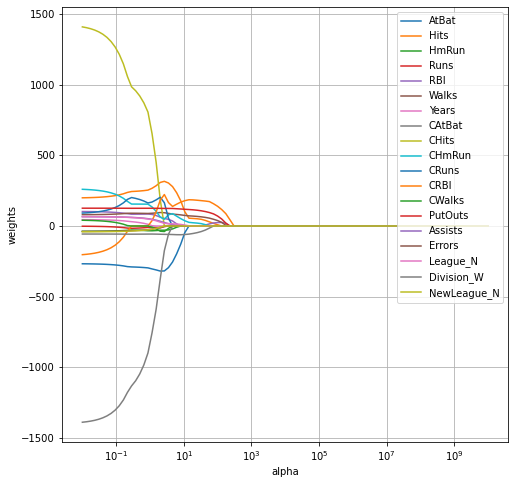

In [64]:
lasso = make_pipeline(StandardScaler(), 
                      Lasso(max_iter = 10000))

def coeff_and_mse(model, 
                  X, y, 
                  X_test=None, y_test=None, 
                  **params):
    estimator = model[-1] if isinstance(model, sklearn.pipeline.Pipeline) else model
    estimator.set_params(**params)
    mse = mean_squared_error(model.fit(X, y).predict(X), y)
    t_mse = mean_squared_error(model.predict(X_test), y_test)
    result = dict(zip(model[:-1].get_feature_names_out(), estimator.coef_))
    result['train_mse'] = mse
    result['test_mse'] = t_mse
    result.update(params)
    return result
    
    
lasso_coef = pd.DataFrame([coeff_and_mse(lasso, X_train, y_train,
                                         X_test, y_test,
                                         alpha=a) for a in alphas]).set_index('alpha')

# coefs = []
# test_err = []

# for a in alphas:
#     lasso['lasso'].set_params(alpha=a)
#     lasso.fit(X_train, y_train)
#     test_err.append(mean_squared_error(y_test, lasso.predict(X_test)))
#     coefs.append(lasso['lasso'].coef_)
    

lasso_coef[X.columns].plot(figsize=(8, 8))
# plt.figure(figsize=(8, 8))
# plt.plot(alphas, coefs, label=X.columns)
plt.legend(loc='upper right')
plt.grid()
plt.xscale('log')
plt.axis('tight')
# plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

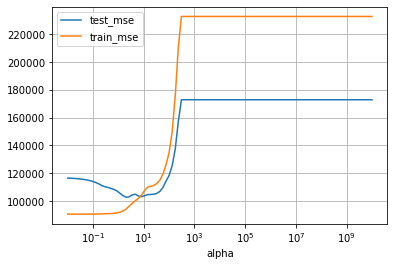

In [67]:
lasso_coef[['test_mse', 'train_mse']].plot()
plt.grid()
plt.xscale('log')
plt.axis('tight')
plt.show()
# plt.xlabel('alpha')
# plt.ylabel('test_error')

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [68]:
np.random.seed(1)

lassocv = make_pipeline(StandardScaler(),
                        LassoCV(alphas = None, cv=10, max_iter = 100000))

lassocv.fit(X_train, y_train)

lasso['lasso'].set_params(alpha=lassocv['lassocv'].alpha_)
lasso.fit(X_train, y_train)
print_result(lasso, X_test, y_test)

--------------------
alpha=27.503283261878394
--------------------
 AtBat      Hits  HmRun  Runs  RBI     Walks  Years  CAtBat  CHits    CHmRun  \
   0.0 50.246197    0.0   0.0  0.0 66.794424    0.0     0.0    0.0 19.441152   

 CRuns       CRBI  CWalks    PutOuts  Assists  Errors  League_N  Division_W  \
   0.0 181.336557     0.0 110.307327     -0.0    -0.0       0.0  -44.530872   

 NewLeague_N  intercept  
         0.0 532.709015  
--------------------
MSE 104960.66
--------------------


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

However, the lasso has a substantial advantage over ridge regression in
that the resulting coefficient estimates are sparse. Here we see that 13 of
the 19 coefficient estimates are exactly zero:

Index(['PutOuts', 'Walks', 'Hits', 'Division_W', 'CHmRun', 'League_N', 'AtBat',
       'RBI', 'HmRun', 'Assists', 'CRuns', 'CAtBat', 'Errors', 'Runs',
       'NewLeague_N', 'CHits', 'Years', 'CRBI', 'CWalks'],
      dtype='object')


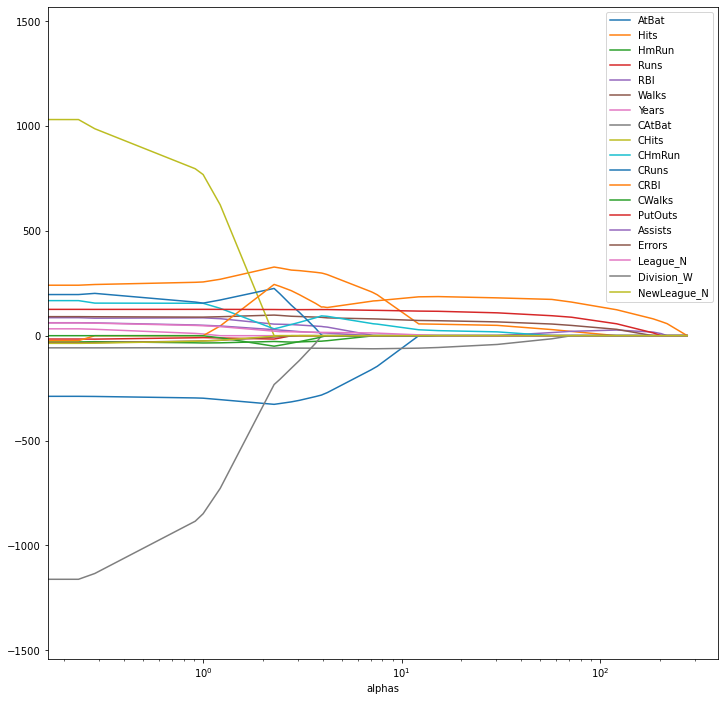

In [69]:

alphas_, active_, coeff_ = lars_path(StandardScaler().fit_transform(X_train), y_train, method='lasso')
result = pd.DataFrame(coeff_.T, columns=X_train.columns)
result['alphas'] = alphas_
result = result.set_index('alphas')

print(X_train.columns[active_])
result.plot(figsize=(12,12))
plt.legend(loc='upper right')
plt.xscale('log')
plt.show()


In [70]:
result.round(2)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
alphas,,,,,,,,,,,,,,,,,,,
275.032833,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
217.592189,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,57.44,0.00,0.00,0.00,0.00,0.00,0.00,0.00
203.284608,0.00,0.00,0.00,0.00,9.92,0.00,0.00,0.00,0.00,0.00,0.00,67.36,0.00,0.00,0.00,0.00,0.00,0.00,0.00
184.899151,0.00,0.00,0.00,0.00,17.21,0.00,0.00,0.00,0.00,0.00,0.00,80.42,0.00,13.49,0.00,0.00,0.00,0.00,0.00
121.291955,0.00,0.00,0.00,0.00,26.88,30.36,0.00,0.00,0.00,0.00,0.00,123.56,0.00,56.68,0.00,0.00,0.00,0.00,0.00
71.780910,0.00,20.21,0.00,0.00,20.88,48.96,0.00,0.00,0.00,0.00,0.00,160.22,0.00,88.05,0.00,0.00,0.00,0.00,0.00
57.147827,0.00,29.08,0.00,0.00,14.81,55.57,0.00,0.00,0.00,0.00,0.00,172.92,0.00,95.16,0.00,0.00,0.00,-14.79,0.00
30.349012,0.00,49.21,0.00,0.00,0.00,65.76,0.00,0.00,0.00,18.20,0.00,180.32,0.00,108.92,0.00,0.00,0.00,-41.79,0.00
15.302196,0.00,54.62,0.00,0.00,0.00,71.36,0.00,0.00,0.00,24.05,0.00,186.36,0.00,116.26,0.00,0.00,0.00,-56.31,0.00
